<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/INPE_CAP351_Projeto02_MLP_Lourenco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-351 Neurocomputação**

**Professor:**
*Dr. Marcos Goncalves Quiles*

**Aluno:**
*Lourenço José Cavalcante Neto*

---

**PROPOSTA DE PROJETO 2: Aprendizado Não Supervisionado**

**Descrição do projeto:**

1. Selecionar 02 (dois) datasets;

2. Aplicar um modelo neural não supervisionado;

3. Avaliar os padrões detectados em cada conjunto:
  * Clusters / outliers, etc.

4. Avaliar a homogeneidade dos agrupamentos;

5. Variar os parâmetros do modelo (grid, taxas, número
de neurônios, etc.).

# **Introdução**

Aprendizado Não Supervisionado são modelos de Machine Learnig que possuem poucos ou nenhum dado histórico para se basear e conseguir prever os resultados, eles não necessitam de um conjunto de dados que digam quais são as variáveis de saídas corretas, para modelar um algoritmo preditivo. Esses modelos conseguem criar estruturas de dados com base em relações entre as variáveis ou detectar algumas tendências.

No presente notebook contém experimentos e testes plicados em um modelo neural não supervisionado. Foi selecionado 01(um) Dataset (não trivial). Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região Amazônica. O disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície.

Foram criadas 5 topologias diferentes, variando o número de camadas. O algoritmo utilizado foi SGD, e foram aplicadas diferentes hyperparâmetros afim de avaliar o impacto do uso do Momentum e da Regularização (L2).

Este notebook pode ser acessado no **github**: https://github.com/lourencocavalcante/Neurocomputacao.git

# **Bibliotecas/Pacotes**

In [1]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=0a3e624aacbc9e11c3bff18da9f3b71f6b3654751330aa62ddc9a48473030bad
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import IsolationForest
seaborn.set()

from google.colab import drive
drive.mount('/content/drive')

#print(tf.__version__)

# **Dataset**
 
Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região amazônica, o Disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície.

## **Importação, Formatação, Tratamento e Visualização dos dados**

In [141]:
#Importando dos dados
df_rd80_dataset = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/Proj2/df_class_rd80.csv")
df_rd80_dataset = pd.DataFrame(df_rd80_dataset)

#Aqui verificamos o tamanho e quantidade de atributos do Dataset
print('Tamanho do dataset: ',df_rd80_dataset.shape[0], ', quantidade de atributos: ', df_rd80_dataset.shape[1])

Tamanho do dataset:  315420 , quantidade de atributos:  13


In [143]:
df_rd80_dataset[['Rain Intensity (mm/h)', 'radar reflectivity (1/mm6m3)',
       'Liquid watercontent (g/m3)', 'Mean weight diameter(mm)',
       'Time integration (s)', 'Class_Rain_id', 'Class_Rain']].head(n=10)

,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s),Class_Rain_id,Class_Rain
0,0.0,0.0,0.0,0.0,60.0,0,Não choveu
1,0.0,0.0,0.0,0.0,60.0,0,Não choveu
2,0.0,0.0,0.0,0.0,60.0,0,Não choveu
3,0.0,0.0,0.0,0.0,60.0,0,Não choveu
4,0.0,0.0,0.0,0.0,60.0,0,Não choveu
5,0.0,0.0,0.0,0.0,60.0,0,Não choveu
6,0.0,0.0,0.0,0.0,60.0,0,Não choveu
7,0.0,0.0,0.0,0.0,60.0,0,Não choveu
8,0.0,0.0,0.0,0.0,60.0,0,Não choveu
9,0.0,0.0,0.0,0.0,60.0,0,Não choveu


In [115]:
df_rd80_dataset = df_rd80_dataset.set_index('Datetime')

In [168]:
df_df_rd80_columns = df_rd80_dataset[['Rain Intensity (mm/h)', 'radar reflectivity (1/mm6m3)', 'Class_Rain_id', 'Class_Rain']]

df_df_rd80 = df_rd80_dataset[['Rain Intensity (mm/h)','radar reflectivity (1/mm6m3)']]


**Padronização dos dados**

In [147]:
df_values = df_df_rd80.values 
df_values = df_values.reshape(-1, len(df_df_rd80.columns))

standardizer = StandardScaler().fit(df_values)
df_std = standardizer.transform(df_values)
df_std = pd.DataFrame(df_std, columns=df_df_rd80.columns)
df_std.describe()

,Rain Intensity (mm/h),radar reflectivity (1/mm6m3)
count,3.154200e+05,3.154200e+05
mean,4.036816e-17,-2.000387e-17
std,1.000002e+00,1.000002e+00
min,-1.089430e-01,-6.575616e-02
25%,-1.089430e-01,-6.575616e-02
50%,-1.089430e-01,-6.575616e-02
75%,-1.089430e-01,-6.575616e-02
max,3.759545e+01,1.169422e+02


**Clusterização - Identificando a anomalia com k-means**

O K-means é um algoritmo do tipo não supervisionado, cujo objetivo é encontrar similaridades entre os dados e agrupá-los em um número de clusteres definidos pelo parâmetro k.

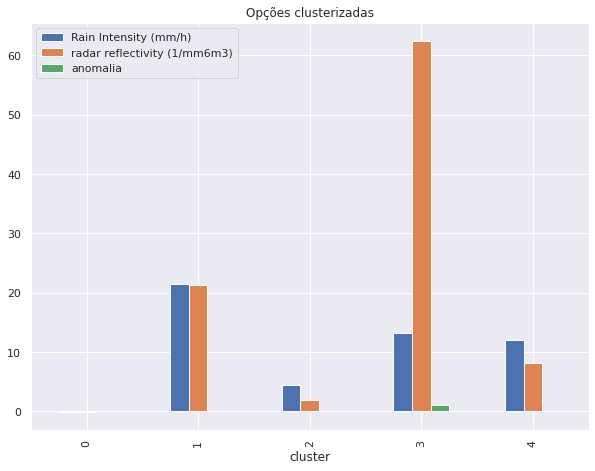

In [184]:
data_array = df_std.values
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
df_std["cluster"] = kmeans.fit_predict(data_array)
df_std.groupby("cluster").aggregate("mean").plot.bar(figsize=(10,7.5))
plt.title("Opções clusterizadas")
plt.show()

In [180]:
modelo = KMeans(n_clusters=5)
modelo.fit(df_std)

modelo.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [181]:
grupos = pd.DataFrame(modelo.cluster_centers_,
                      columns=df_std.columns)

grupos

,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),cluster,anomalia
0,-0.082063,-0.058336,-1.385281e-13,-9.351244e-17
1,11.958710,8.170266,2.000000e+00,-4.472334e-19
2,4.499670,1.978572,4.000000e+00,1.761829e-18
3,21.400560,21.295816,1.007663e+00,3.831418e-03
4,13.233020,62.376816,3.000000e+00,1.000000e+00


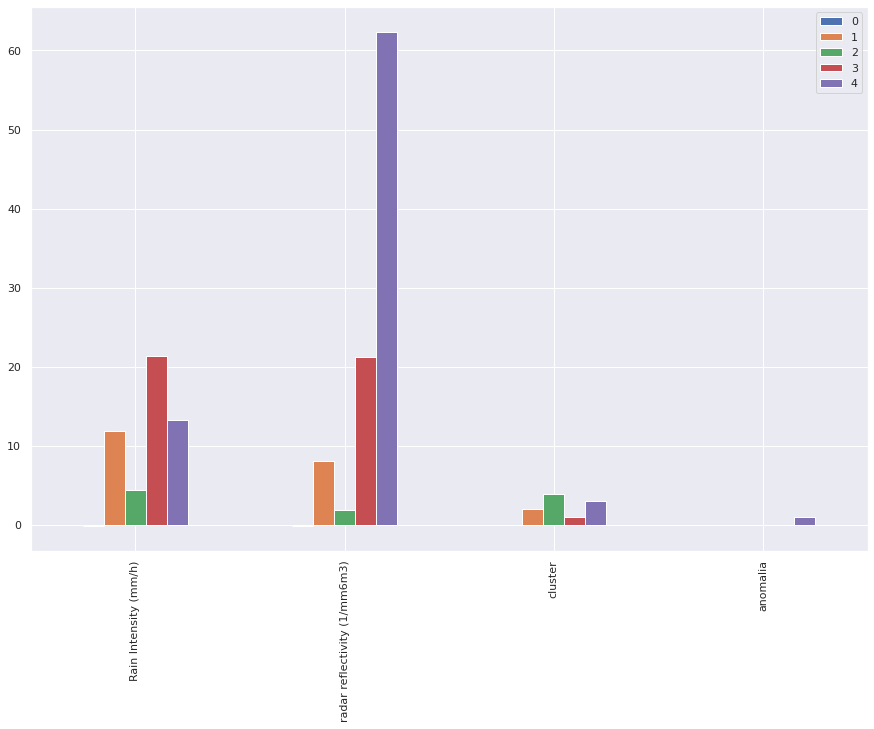

In [183]:
grupos.transpose().plot.bar(
                            figsize=(15,10),
                            sharex=False)

O gráfico mostra que dentre os clusteres encontrados pelo modelo, há um que foge do comportamento padrão: o cluster 1. Os registros agrupados nesse cluster serão definidos como anômalos.

**Definir label para anomalia**

In [149]:
df_std['anomalia'] = 0
df_std.loc[df_std['cluster'] == 3, 'anomalia'] = 1

In [150]:
df_std.loc[(df_std['anomalia']) == 1].head(10)

,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),cluster,anomalia
484,10.469734,68.969928,3,1
1513,9.333726,61.509942,3,1
5828,8.810894,57.864817,3,1
6157,11.469211,75.100045,3,1
6249,10.197346,67.115045,3,1
8367,9.431255,61.795342,3,1
9708,9.224853,60.664476,3,1
9901,9.117908,59.802836,3,1
19039,7.617412,50.312682,3,1
19040,7.612706,50.310803,3,1


**Visualizando os clusteres formados**

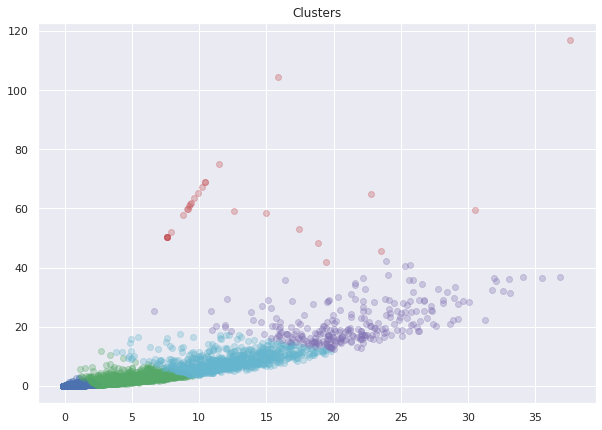

In [151]:
cor = ['b', 'g', 'r', 'c', 'm', 'y']
i=0

plt.figure(figsize=(10,7))
for cluster in df_std['cluster'].unique():
    df = df_std.loc[df_std['cluster'] == cluster]
    
    plt.scatter(df['Rain Intensity (mm/h)'], df['radar reflectivity (1/mm6m3)'], c=cor[i],alpha=0.3)
    i += 1
plt.title("Clusters")
plt.show()

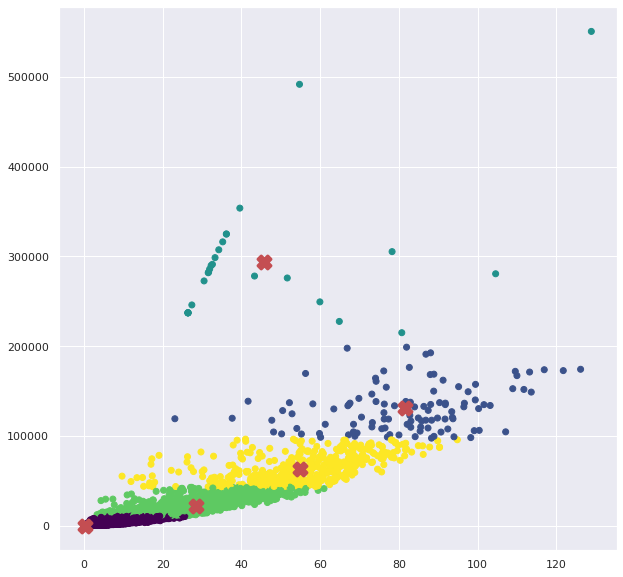

In [185]:

grupos_ = modelo.fit_predict(df_df_rd80)
centroides = modelo.cluster_centers_

plt.scatter(x=df_df_rd80['Rain Intensity (mm/h)'],
            y=df_df_rd80['radar reflectivity (1/mm6m3)'],
            c= grupos_,
            cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1],
           marker='X', s=169, linewidths=3,
           color='r', zorder=8)

**Visualizando o cluster anômalo**

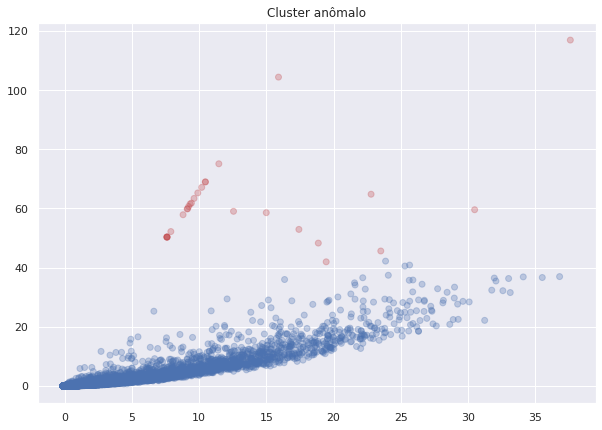

In [152]:
cor = []
plt.figure(figsize=(10,7))
for anomalia in df_std['anomalia'] :
    if anomalia == 1 :
        cor.append('r')
    else :
        cor.append('b')
plt.scatter(df_std['Rain Intensity (mm/h)'], df_std['radar reflectivity (1/mm6m3)'], c=cor,alpha=0.3)
plt.title("Cluster anômalo")
plt.show()

**Criando modelo de classificação**

In [153]:
def particionaDados(X, Y, treinamento=.75, teste=.25, random_state=42):
    percentual_teste_validacao = 1 - treinamento
    X_treino, X_temp, Y_treino, Y_temp = train_test_split(X, Y, test_size=percentual_teste_validacao, 
        random_state=random_state)
    
    if(treinamento + teste < 1):
        validacao = 1 - (treinamento + teste)
        percentual_validacao = validacao / percentual_teste_validacao
        
        X_teste, X_validacao, Y_teste, Y_validacao = train_test_split(X_temp, Y_temp, test_size=percentual_validacao,
        random_state=random_state)
    else:
        X_teste = X_temp
        Y_teste = Y_temp
        X_validacao = []
        Y_validacao = [] 
   
    return (X_treino, X_teste, X_validacao, Y_treino, Y_teste, Y_validacao)

In [154]:
def treinaKNN(k, p, X_treino, Y_treino, X_teste, Y_teste):
    classificador = KNeighborsClassifier(n_neighbors=k, p=p)
    classificador.fit(X_treino, Y_treino.ravel())

    y_pred = classificador.predict(X_teste)

    return (confusion_matrix(Y_teste, y_pred), accuracy_score(Y_teste, y_pred), classificador)

In [155]:
df_std.head(n=10)

,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),cluster,anomalia
0,-0.108943,-0.065756,0,0
1,-0.108943,-0.065756,0,0
2,-0.108943,-0.065756,0,0
3,-0.108943,-0.065756,0,0
4,-0.108943,-0.065756,0,0
5,-0.108943,-0.065756,0,0
6,-0.108943,-0.065756,0,0
7,-0.108943,-0.065756,0,0
8,-0.108943,-0.065756,0,0
9,-0.108943,-0.065756,0,0


In [156]:
X = df_std.iloc[:,0:2].values
Y = df_std.iloc[:,3:].values

X_treino, X_teste, X_validacao, Y_treino, Y_teste, Y_validacao = particionaDados(X,Y,.75,.25)

len(df_std), len(X_treino), len(X_teste), len(X_validacao) , len(Y_treino), len(Y_teste), len(Y_validacao)

(315420, 236565, 78855, 0, 236565, 78855, 0)

In [157]:
matrizes = {}
acuracias = {}
for k in [1,3,5,7]:
    treinamento = treinaKNN(k,2, X_treino, Y_treino, X_teste, Y_teste)
    matrizes[k] = treinamento[0]
    acuracias[k] = treinamento[1]

<Figure size 1280x800 with 0 Axes>

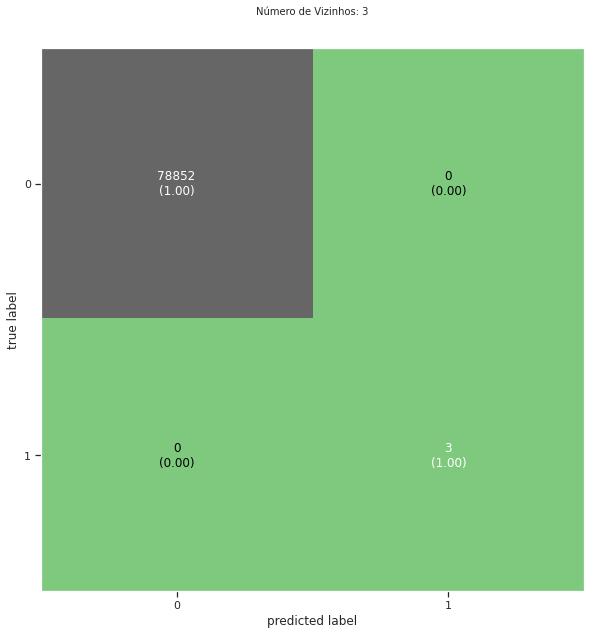

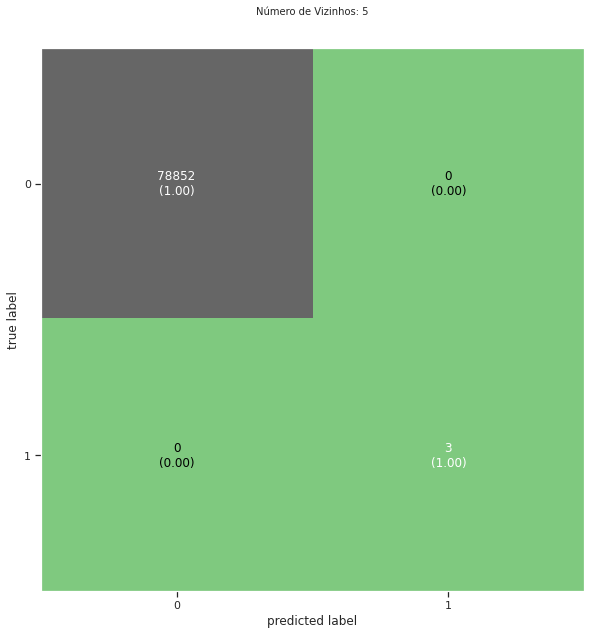

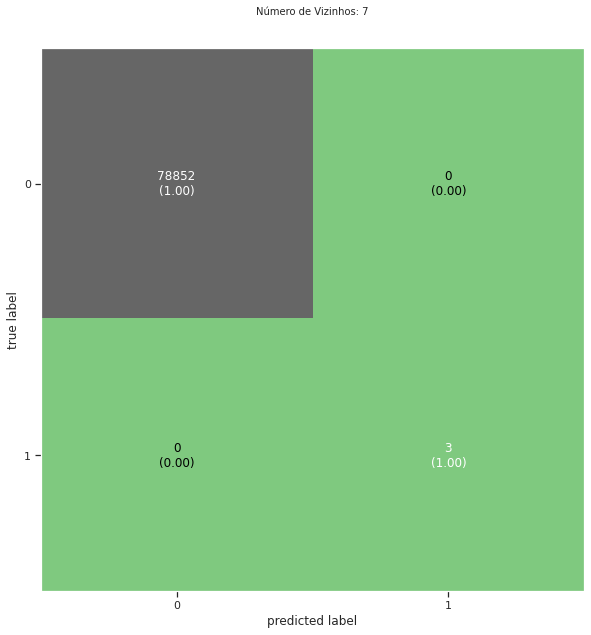

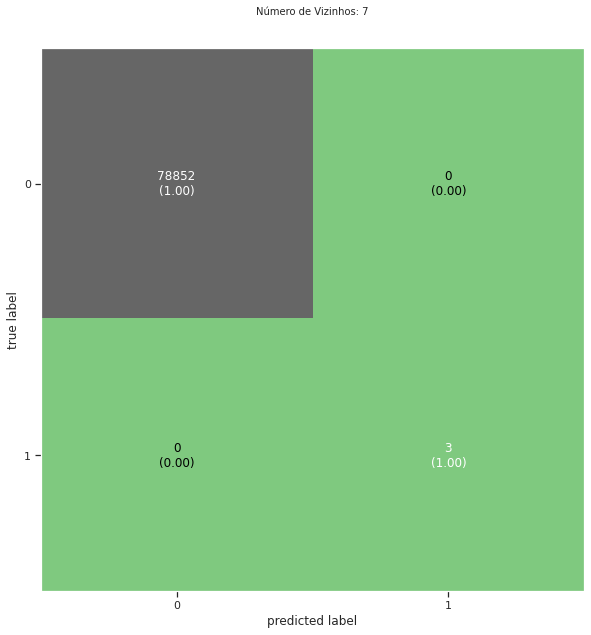

In [158]:
a = 0
plt.figure(figsize=(16,10),dpi=80)
plt.suptitle('TOPOLOGIA II: AVALIAÇÃO', size=14)
for k, matriz in matrizes.items():
      a = a + 1
      ax.set_title('Número de Vizinhos: ' + str(k), fontsize = 10, )
      fig, ax = plot_confusion_matrix(conf_mat=matriz, show_absolute=True, show_normed=True, cmap='Accent')
      ax.set_title('Número de Vizinhos: ' + str(k), fontsize = 10)
plt.show()

In [175]:
acuracias

{1: 1.0, 3: 1.0, 5: 1.0, 7: 1.0}